# Modeling the Affinity of Customers

## Import libraries

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# Scalers
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.linear_model import LogisticRegression

# Cross validation
from sklearn.model_selection import cross_val_score

# Train/test split
from sklearn.model_selection import train_test_split

## Exploratory Data Analysis

In [219]:
# Import csv files as pandas dataframe
customer = pd.read_csv("data/rest.csv", sep = ";")
age_and_sex = pd.read_csv("data/alter_geschlecht.csv")
interest = pd.read_csv("data/interesse.csv")

In [220]:
customer.head()

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id
0,1,15.0,1,1-2 Year,No,2630.0,124.0,74,317635
1,1,28.0,0,1-2 Year,Yes,2630.0,125.0,213,337993
2,1,33.0,0,1-2 Year,Yes,27204.0,124.0,114,160325
3,1,46.0,1,< 1 Year,No,31999.0,152.0,251,141620
4,1,49.0,0,1-2 Year,Yes,28262.0,26.0,60,75060


In [221]:
age_and_sex.head()

,id,Geschlecht,Alter
0,170727,Male,42
1,41795,Male,24
2,369321,Female,30
3,500463,Female,32
4,327695,Male,34


In [222]:
interest.head()

,id,Interesse
0,1,1.0
1,2,0.0
2,3,1.0
3,4,0.0
4,5,0.0


In [223]:
# Exploring lenght of the tables
print(len(customer))
print(len(age_and_sex))
print(len(interest))

508146
508146
381109


Interest table contains fewer rows than two other tables => In this scenario, we should only keep the rows in the "customer" and "age_and_sex" dataframes that match the IDs in the "interest" dataframe since the "interest" dataframe contains the target variable we want to predict. The rest we can keep for predicting after training the model

In [224]:
# Merge dataframes -> use left join for interest table
data = interest.merge(age_and_sex, on='id', how='left')
data = data.merge(customer, on='id', how='left')
data.head()

,id,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
0,1,1.0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,2,0.0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
2,3,1.0,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
3,4,0.0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
4,5,0.0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39


In [225]:
# Examine the structure of the table
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               381109 non-null  int64  
 1   Interesse        381109 non-null  float64
 2   Geschlecht       381109 non-null  object 
 3   Alter            381109 non-null  int64  
 4   Fahrerlaubnis    381109 non-null  int64  
 5   Regional_Code    381109 non-null  float64
 6   Vorversicherung  381109 non-null  int64  
 7   Alter_Fzg        381109 non-null  object 
 8   Vorschaden       381109 non-null  object 
 9   Jahresbeitrag    381109 non-null  float64
 10  Vertriebskanal   381109 non-null  float64
 11  Kundentreue      381109 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 37.8+ MB
None


In [226]:
# Explore missing values
print(data.isna().sum()) # -> no missing values

id                 0
Interesse          0
Geschlecht         0
Alter              0
Fahrerlaubnis      0
Regional_Code      0
Vorversicherung    0
Alter_Fzg          0
Vorschaden         0
Jahresbeitrag      0
Vertriebskanal     0
Kundentreue        0
dtype: int64


In [227]:
# Explore duplicated rows
print(data.duplicated().sum()) # -> no duplicates

0


In [228]:
# Detecting outliers

# Check categorical features on unexpected values
print(data["Interesse"].unique())
print(data["Geschlecht"].unique())
print(data["Fahrerlaubnis"].unique())
print(data["Vorversicherung"].unique())
print(data["Alter_Fzg"].unique())
print(data["Vorschaden"].unique())

[1. 0.]
['Male' 'Female']
[1 0]
[0 1]
['> 2 Years' '1-2 Year' '< 1 Year']
['Yes' 'No']


In [229]:
# Check values in Regional_Code
np.sort(data['Regional_Code'].unique()) # -> 53 regions

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

In [230]:
# Check values in Vertriebskanal
np.sort(data['Vertriebskanal'].unique()) # -> 163 channels

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  73.,  74.,  75.,  76.,  78.,  79.,  80.,
        81.,  82.,  83.,  84.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
       115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
       126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
       137., 138., 139., 140., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 15

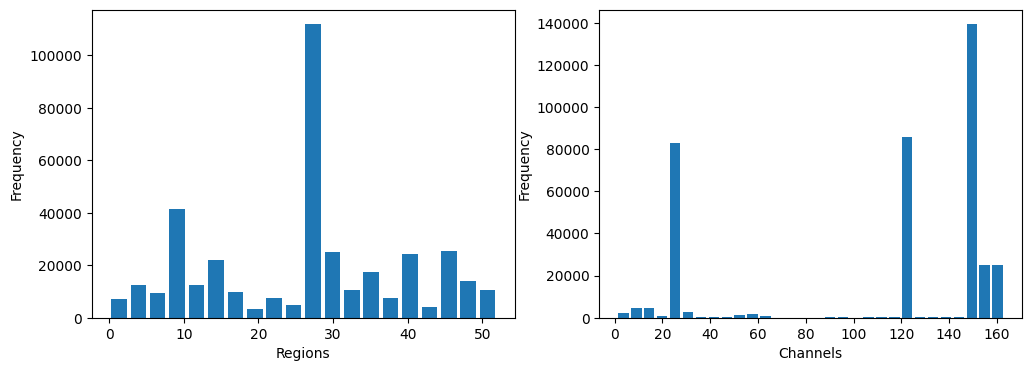

In [231]:
# Check Regional_Code and Vertriebskanal distribution
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(data['Regional_Code'], bins=20, rwidth=0.8)
plt.xlabel('Regions')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['Vertriebskanal'], bins=30, rwidth=0.8)
plt.xlabel('Channels')
plt.ylabel('Frequency')

plt.show()

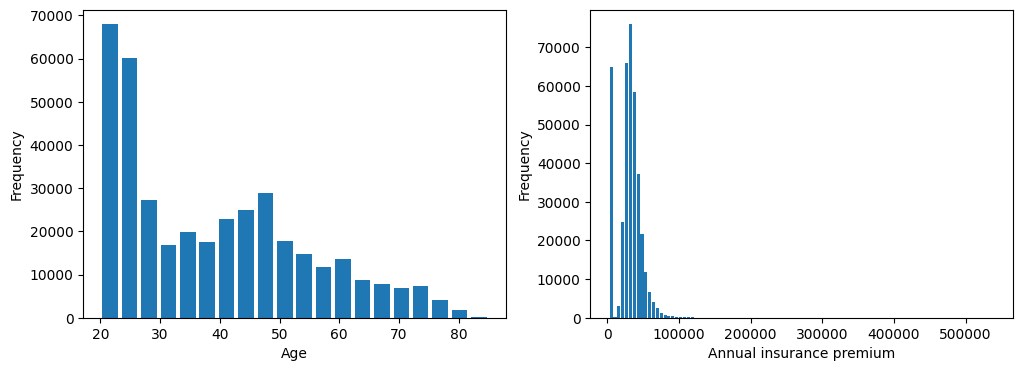

In [232]:
# Check numerical features

# Check age and annual premium
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(data['Alter'], bins=20, rwidth=0.8)
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['Jahresbeitrag'], bins=100, rwidth=0.8)
plt.xlabel('Annual insurance premium')
plt.ylabel('Frequency')

plt.show()

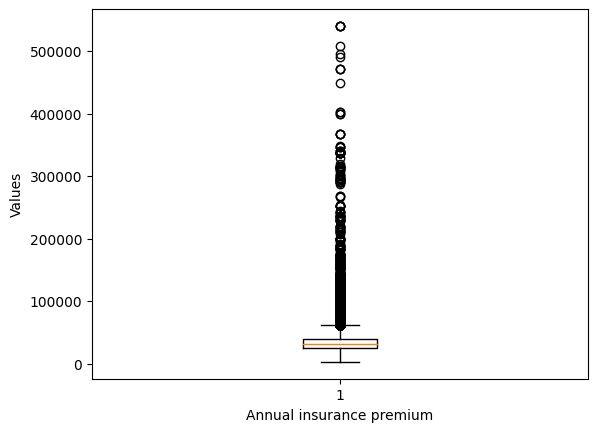

In [233]:
# Plot boxplot of Jahresbeitrag column
plt.boxplot(data['Jahresbeitrag'])
plt.xlabel('Annual insurance premium')
plt.ylabel('Values')
plt.show()

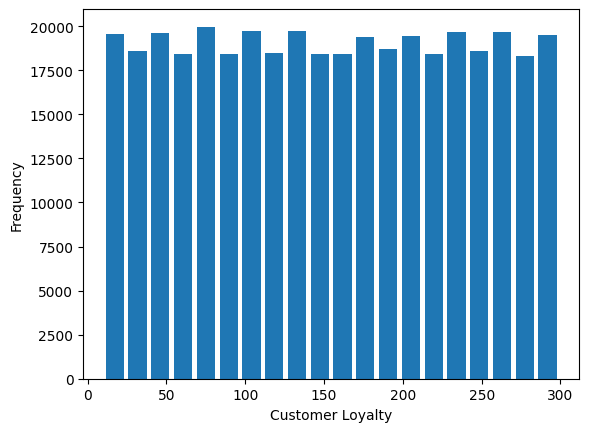

In [234]:
# Check values in Kundentreue
plt.hist(data['Kundentreue'], bins=20, rwidth=0.8)
plt.xlabel('Customer Loyalty')
plt.ylabel('Frequency')
plt.show()

Conclusions:
We have 7 categoracal variables: Geschlecht, Fahrerlaubnis, Regional_Code, Vorversicherung, Alter_Fzg, Vorschaden and Vertriebskanal. Some of them need to be encoded:
* Geschlecht -> one-hot-encoding since they don't have ordinal structure
* Alter_Fzg -> ordinal encoder since they have hierarchy
* Vorschaden -> label encoder that put 1 if there are previous damages and 0 if not
* Regional_Code and Vertriebskanal -> it is necessary to encode them using different strategy since some algorithms are sensitive to the ordering of the categories and may assign a higher weight to categories with larger numerical values -> use target encoding

Our numerical values are: Alter, Jahresbeitrag and Kundentreue.

* Jahresbeitrag -> has a lot of extreme values but I think that they are full part of the dataset and shouldn't be removed -> MinMax Scaling
* Alter -> MinMax Scaling as for Jahresbeitrag. Also, it may make sense to discretize Alter column into groups according to car accident statistics (https://www.gdv.de/gdv/themen/mobilitaet/so-wirkt-sich-das-alter-auf-den-kfz-versicherungsbeitrag-aus-12464)
* Kundentreue -> MinMax Scaling as for Jahresbeitrag

Note: I will first proceed with logistic regression, such algorithms assume that the input variables are on the same scale and that the scale of the coefficients is meaningful. That is why I need to scale my variables. I will also later try other algorithms such as random forest. Such algorithms are not sensitive to the scale of the features, so normalization or scaling is not necessary. But still scaling doesn't hurt.

## Normalizing, Encoding, and Feature Engineering

Note: I realize that I can implement this step as a part of pipeline. However, I want to run some preliminary statistical analysis and check correlation between variables once I transform them

### Categorical Variables

In [235]:
# Geschlecht

# Instantiate the OneHotEncoder
ohe_binary = OneHotEncoder(sparse = False, drop="if_binary") 

# Fit encoder
ohe_binary.fit(data[['Geschlecht']]) 

# Transform the current "Geschlecht" column
data[ohe_binary.get_feature_names_out()] = ohe_binary.transform(data[['Geschlecht']])

# Drop the column "Geschlecht" which has been encoded
data.drop(columns = ["Geschlecht"], inplace = True)

In [236]:
# Alter_Fzg

# Instantiate the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Define the mapping for each category in the "Alter_Fzg" column
ordinal_mapping = {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}

# Creating an array that contains the categories of the "Alter_Fzg" column
Alter_Fzg_array = data['Alter_Fzg'].map(lambda x: ordinal_mapping[x]).values.reshape(-1, 1)

# Fit and transform the Alter_Fzg_array to a numerical representation
Alter_Fzg_encoded = ordinal_encoder.fit_transform(Alter_Fzg_array)

# Adding the encoded "Alter_Fzg" column to the original dataframe
data['Alter_Fzg_enc'] = Alter_Fzg_encoded

# Drop the column "Alter_Fzg" which has been encoded
data.drop(columns = ["Alter_Fzg"], inplace = True)

In [237]:
# Vorschaden

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the Vorschaden column
data['Vorschaden'] = le.fit_transform(data['Vorschaden'].values)

In [238]:
# Regional_Code and Vertriebskanal 

# Import function from utils
from utils.functions import calc_target_encoding

# Apply function to Regional_Code and Vertriebskanal columns
target_mean_regional = calc_target_encoding(data, 'Regional_Code', 'Interesse')
target_mean_channel = calc_target_encoding(data, 'Vertriebskanal', 'Interesse')

# Apply target encoding to the original data
data['Regional_Code_enc'] = data['Regional_Code'].map(target_mean_regional)
data['Vertriebskanal_enc'] = data['Vertriebskanal'].map(target_mean_channel)

# Drop columns which have been encoded
data.drop(columns = ["Regional_Code"], inplace = True)
data.drop(columns = ["Vertriebskanal"], inplace = True)

In [239]:
data.head()

,id,Interesse,Alter,Fahrerlaubnis,Vorversicherung,Vorschaden,Jahresbeitrag,Kundentreue,Geschlecht_Male,Alter_Fzg_enc,Regional_Code_enc,Vertriebskanal_enc
0,1,1.0,44,1,0,1,40454.0,217,1.0,2.0,0.187163,0.199385
1,2,0.0,76,1,0,0,33536.0,183,1.0,1.0,0.127662,0.199385
2,3,1.0,47,1,0,1,38294.0,27,1.0,2.0,0.187163,0.199385
3,4,0.0,21,1,1,0,28619.0,203,1.0,0.0,0.112760,0.028624
4,5,0.0,29,1,1,0,27496.0,39,0.0,0.0,0.121776,0.028624


### Numerical Variables

In [240]:
# Discretize Alter column
bins = [0, 30, 50, 65, 75, 100]
bin_labels = ['<30', '30-50', '50-65', '65-75', '>75']
data['Alter_binned'] = pd.cut(data['Alter'], bins=bins, labels=bin_labels, right=False)

In [241]:
# one-hot encode the Alter_binned column
data = pd.get_dummies(data, columns=['Alter_binned'])

In [242]:
# Normalizing numerical columns

# Select the columns to be normalized
columns_to_normalize = ['Jahresbeitrag', 'Alter', 'Kundentreue']

# create an instance of MinMaxScaler
scaler = MinMaxScaler()

# fit and transform the data
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

In [244]:
data.head()

,id,Interesse,Alter,Fahrerlaubnis,Vorversicherung,Vorschaden,Jahresbeitrag,Kundentreue,Geschlecht_Male,Alter_Fzg_enc,Regional_Code_enc,Vertriebskanal_enc,Alter_binned_<30,Alter_binned_30-50,Alter_binned_50-65,Alter_binned_65-75,Alter_binned_>75
0,1,1.0,0.369231,1,0,1,0.070366,0.716263,1.0,2.0,0.187163,0.199385,0,1,0,0,0
1,2,0.0,0.861538,1,0,0,0.057496,0.598616,1.0,1.0,0.127662,0.199385,0,0,0,0,1
2,3,1.0,0.415385,1,0,1,0.066347,0.058824,1.0,2.0,0.187163,0.199385,0,1,0,0,0
3,4,0.0,0.015385,1,1,0,0.048348,0.667820,1.0,0.0,0.112760,0.028624,1,0,0,0,0
4,5,0.0,0.138462,1,1,0,0.046259,0.100346,0.0,0.0,0.121776,0.028624,1,0,0,0,0


## Preliminary Statistical Analysis

In [245]:
# Drop the column "id" since we don't need it anymore
data.drop(columns = ["id"], inplace = True)

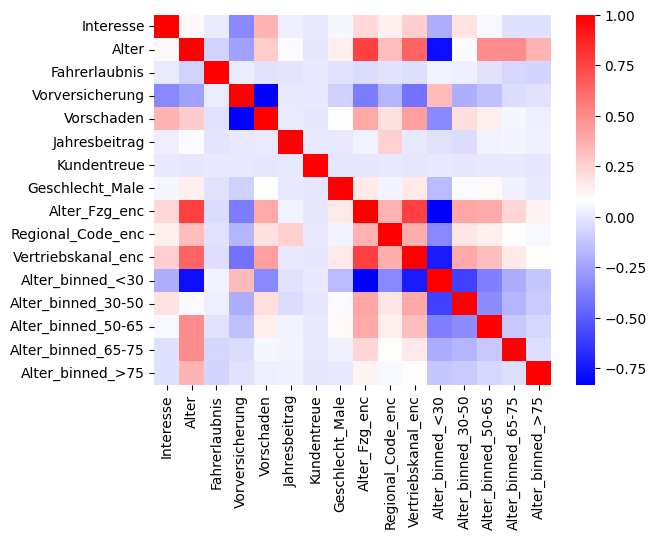

In [246]:
# Heatmap of pairwise correlations
correlation_matrix = data.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

In [247]:
# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [248]:
# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showing the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*2)

,feature_1,feature_2,correlation,absolute_correlation
139,Alter_Fzg_enc,Alter_binned_<30,-0.830648,0.830648
184,Alter_binned_<30,Alter_Fzg_enc,-0.830648,0.830648
52,Vorversicherung,Vorschaden,-0.824143,0.824143
67,Vorschaden,Vorversicherung,-0.824143,0.824143
27,Alter,Alter_binned_<30,-0.787733,0.787733
177,Alter_binned_<30,Alter,-0.787733,0.787733
168,Vertriebskanal_enc,Alter_Fzg_enc,0.768908,0.768908
138,Alter_Fzg_enc,Vertriebskanal_enc,0.768908,0.768908
129,Alter_Fzg_enc,Alter,0.765790,0.765790
24,Alter,Alter_Fzg_enc,0.765790,0.765790


## Modelling

In [253]:
# Defining target and the features
y = data['Interesse']
X = data.drop(columns=['Interesse'])

In [254]:
# Instantiate model
log_reg = LogisticRegression(max_iter=1000) 

# Scoring on multiple folds aka Cross Validation
scores = cross_val_score(log_reg, X, y, cv=10)
scores.mean()

0.877323810261565

In [ ]:
n_split = 5
len_split = int(data.shape[0]/n_split)

# Select only  numerical values for this example
data_num = data.select_dtypes(exclude=['object'])

# Shuffle the dataset rows
data_num = data_num.sample(frac=1)

# Initialize the 1st fold
scores = []
start = 0
stop = len_split

# Start the n-split fold CV
for k in range(n_split): # k in [0,1,2,3,4]
    data_val = data_num.iloc[start:stop, :]
    data_train = data_num.drop(index=data_val.index)
    y_train = data_train['SalePriceBinary']
    X_train = data_train.drop(columns=['SalePriceBinary'])
    y_val = data_val['SalePriceBinary']
    X_val = data_val.drop(columns=['SalePriceBinary'])
    robust = RobustScaler()
    
    # Train the Robustscaler only on train set to avoid data leakage 👌
    X_train['GrLivArea'] = robust.fit_transform(X_train[['GrLivArea']])
    log =  LogisticRegression(max_iter=1000)
    log.fit(X_train, y_train)
    
    # Apply robust scaling to val set
    X_val['GrLivArea'] = robust.transform(X_val[['GrLivArea']])
    scores.append(log.score(X_val, y_val))
    
    # Setup next fold
    start = stop
    stop += len_split

# Display the mean score and the scores standard deviation
print(np.array(scores).mean())
print(np.array(scores).std())

In [88]:
data['Jahresbeitrag'].min()

2630.0

In [111]:
data['Jahresbeitrag'].max()

540165.0

In [68]:
mean = data['Jahresbeitrag'].mean()
std = data['Jahresbeitrag'].std()

data['z_score'] = (data['Jahresbeitrag'] - mean) / std
threshold = 3
outliers = data[data['z_score'] > threshold]


In [85]:
outliers['Jahresbeitrag'].max()

540165.0

In [86]:
outliers['Jahresbeitrag'].min()

61893.0

In [90]:
outliers_max = outliers['Jahresbeitrag'].max()
row = data[data['Jahresbeitrag'] == outliers_max]
row

,id,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,z_score
54743,54744,1.0,Male,26,1,28.0,0,< 1 Year,Yes,540165.0,156.0,245,29.605299
144282,144283,0.0,Female,53,1,28.0,1,1-2 Year,No,540165.0,26.0,134,29.605299
190154,190155,0.0,Male,47,1,28.0,0,1-2 Year,Yes,540165.0,42.0,24,29.605299
268332,268333,0.0,Male,46,1,28.0,0,1-2 Year,Yes,540165.0,124.0,59,29.605299
